# Mathematical Engineering - Financial Engineering, FY 2024-2025
# Risk Management - Exercise 3: Equity Portfolio VaR/ES and Counterparty Risk

In [1]:
# Importing libraries and loading data
import os
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime, timedelta
from utilities import zeroRates
from bootstrap import bootstrap
import datetime as dt


import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

from ex1_utilities import (
    business_date_offset,
    year_frac_act_x,
    year_frac_act_xNEW,
    get_discount_factor_by_zero_rates_linear_interp,
)
from ex3_utilities import (
    gaussian_var_es,
    hs_var_es,
    principal_component_analysis,
    plausility_check,
    black_scholes_option_pricer,
)

from utilities import read_mat_file_dates
from utilities import read_mat_file_rates
from utilities import convert_date_to_string
# !!! IMPORT PRICES AND TICKERS DATA !!!
prices_df = pd.read_csv('sx5e_underlyings.csv',index_col ='Date', parse_dates = True) # sx5e_underlyings.csv
tickers_df = pd.read_csv('ticker_details.csv',usecols=[1,2]) # ticker_details.csv
# prices = pd.read_csv("sx5e_underlyings.csv")


In [2]:
# !!! READ MARKET AND BOOTSTRAP DATA !!!
datesSet = read_mat_file_dates("datesSet.mat")
datesSetNew = {"settlement":convert_date_to_string(datesSet["settlement"]), "depos": convert_date_to_string(datesSet["depos"]),
               "futures_settlement": convert_date_to_string(datesSet["futures_settlement"]), "futures_expiry": convert_date_to_string(datesSet["futures_scadenza"]),
               "swaps": convert_date_to_string(datesSet["swaps"])}
ratesSet = read_mat_file_rates("ratesSet.mat")
[dates, discounts] = bootstrap(datesSetNew,ratesSet)
discounts = [1] +  discounts
dates = datesSetNew["settlement"] + dates
dates = [dt.datetime.strptime(date, "%Y-%m-%d") for date in dates]
today = dates[0]
discount_factors = discounts

In [3]:
date = pd.Timestamp(2020, 1, 31)
alpha = 0.95  # Significance level

log_returns = np.log(prices_df).diff()
log_returns.index = pd.to_datetime(log_returns.index)
log_returns.bfill(inplace=True)

In [4]:
# Case Study 1 - Q1: Compute daily VaR and ES with a 4y estimation using the dataset provided via Gaussian
# parametric approach.

# Sets a 4-year window for historical data
time_horizon1 = 4  # In years
ptf_notional = 25e6  # Portfolio notional in euros

# Calculates the start date by subtracting 4 years from the current date
start_date1 = date - relativedelta(years=time_horizon1)

# !!! COMPLETE APPROPRIATELY !!!
# Names of the stocks in the portfolio
names=["BMW","BNP Paribas","Danone","Nokia","TotalEnergies"]

# Retrieves the tickers corresponding to the names above
portfolio1_stocks = tickers_df[tickers_df["Name"].isin(names)]["Ticker"].values

# An alternative way to assign equal weights (commented out) is shown above; here each stock has a 20% weight
# weights = 1/5 * pd.Series([1, 1, 1, 1, 1], index=portfolio1_stocks)
weights = pd.Series([0.2] * 5,index=portfolio1_stocks)

# Selects the log returns for the chosen time window and stocks
returns1 = log_returns.loc[start_date1:date, weights.index]

# Computes the mean of the log returns
mu = log_returns.loc[start_date1:date, weights.index].mean()
# Computes the covariance matrix of the log returns
sigma = log_returns.loc[start_date1:date, weights.index].cov()

# Calculates VaR and ES using the Gaussian parametric approach
VaR_1, ES_1 = gaussian_var_es(mu, sigma, alpha, weights, ptf_notional)

# Prints the resulting VaR and ES for the portfolio
print(f"Case Study 1 - Q1: Gaussian VaR: €{VaR_1:,.5f}, ES: €{ES_1:,.5f}")


Case Study 1 - Q1: Gaussian VaR: €415,319.47587, ES: €520,494.47226


In [5]:
# Case Study 1 - Q2: Historical Simulation and Bootstrap

# Defines the time horizon for the historical window (3 years)
time_horizon2 = 3

# Calculates the start date by subtracting 3 years from the current date
start_date2 = date - relativedelta(years=time_horizon2)

# !!! COMPLETE APPROPRIATELY !!!

# Lists the names of the selected stocks
names = ["Adidas", "Allianz", "ASML", "Deutsche Boerse"]
# Filters the tickers_df DataFrame to keep only the tickers matching the names above
portfolio2_stocks = tickers_df[tickers_df['Name'].isin(names)]['Ticker']

# Defines the number of shares for each stock
shares_num = pd.Series([25e3, 20e3, 20e3, 10e3], index=portfolio2_stocks)

# Retrieves the current prices for the chosen stocks on the specified date
current_prices = (prices_df.loc[date, portfolio2_stocks])

# Computes the portfolio's notional by multiplying current prices by the number of shares
ptf2_notional = np.dot(current_prices, shares_num)

# Computes the weights of each stock in the portfolio
weights2 = current_prices * shares_num / ptf2_notional  # Weights of the stocks in the portfolio

# Selects the log returns for the chosen period and stocks
returns2 = log_returns.loc[start_date2:date, portfolio2_stocks]

""""FE 25 - RM3.docx"
portfolio2_stocks = prices_df[['ADSGn.DE','ALVG.DE','ASML.AS','DB1Gn.DE']][start_date2:date]
shares_num = np.array([25000,20000,20000,10000])
ptf2_notional = sum(portfolio2_stocks.iloc[0]*shares_num)
weight_share=shares_num/sum(shares_num)
weights2 = (pd.Series(weight_share*portfolio2_stocks.iloc[0]/sum(weight_share*portfolio2_stocks.iloc[0]), index=portfolio2_stocks.columns))
returns2= np.log(portfolio2_stocks).diff().dropna()
""""FE 25 - RM3.docx"

# HS (Historical Simulation)
VaR_2, ES_2 = hs_var_es(returns2, alpha, weights2, ptf2_notional)
print(f"Case Study 1 - Q2: HS VaR: €{VaR_2:,.2f}, ES: €{ES_2:,.2f}")

# Sets a random seed for reproducibility
np.random.seed(5)

# Bootstrap approach for VaR and ES estimation
simulations_num = 300  # Defines how many random samples to draw; may need more for accurate convergence
VaR_2_bootstrap, ES_2_bootstrap = hs_var_es(
    returns2.sample(simulations_num, replace=True),
    alpha,
    weights2,
    ptf2_notional,
)
print(
    f"Case Study 1 - Q2: Bootstrap VaR: €{VaR_2_bootstrap:,.2f}, ES: €{ES_2_bootstrap:,.2f}€"
)


Case Study 1 - Q2: HS VaR: €315,086.53, ES: €466,044.00
Case Study 1 - Q2: Bootstrap VaR: €293,159.31, ES: €402,208.21€


In [6]:
# Case Study 1 - Q3: WHS

# Defines the smoothing parameter (lambda) for Weighted Historical Simulation (WHS)
lambda_ = 0.95

# Establishes the start date by subtracting 4 years from the current date
start_date3 = date - relativedelta(years=4)

# Sets the notional value for the portfolio
ptf3_notional = 25e6

# Specifies the names of the stocks to be included
names = ["Airbus", "BBVA", "BMW", "Eni", "ING Group", "Schneider Electric"]

# Retrieves the tickers of the selected stocks
portfolio3_stocks = tickers_df[tickers_df['Name'].isin(names)]['Ticker']  # Tickers of the stocks in the portfolio

# Assigns equal weights to each stock in the portfolio
weights3 = pd.Series([1/6] * 6, index=portfolio3_stocks)

# Selects the log returns for the chosen time window and stocks
returns3 = log_returns.loc[start_date1:date, weights3.index]

# Performs Weighted Historical Simulation to compute VaR and ES
VaR_3, ES_3 = hs_var_es(
    returns3,
    alpha,
    weights3,
    ptf_notional,
    lambda_=lambda_,
)

# Prints the results for VaR and ES
print(f"Case Study 1 - Q3: WHS VaR: €{VaR_3:,.2f}, ES: €{ES_3:,.2f}")


Case Study 1 - Q3: WHS VaR: €384,278.00, ES: €598,372.87


c:\Users\PC-Tommaso\Desktop\FE_LAB\LAB_RM_03\ex3_utilities.py:181: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sorted_losses = weighted_losses[sorted_indices] # Ordina le perdite ponderate
c:\Users\PC-Tommaso\Desktop\FE_LAB\LAB_RM_03\ex3_utilities.py:182: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sorted_weights = decay_weights[sorted_indices] # Ordina i pesi
c:\Users\PC-Tommaso\Desktop\FE_LAB\LAB_RM_03\ex3_utilities.py:185: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

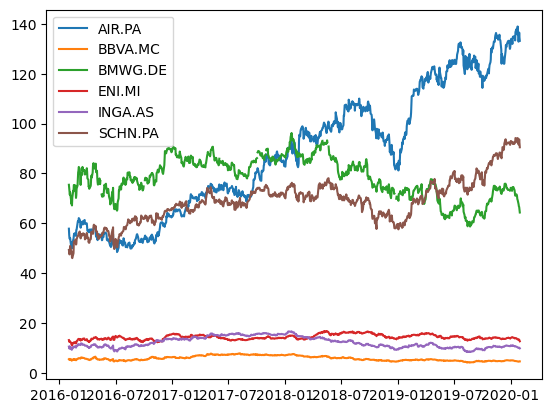

In [7]:
plt.plot(prices_df.loc[start_date1:date, weights3.index])
plt.legend(weights3.index)

In [8]:
# Case Study 1 - Q4: PCA
delta = 10  # Sets the horizon parameter for scaling risk measures (e.g., 10 days)

# !!! COMPLETE APPROPRIATELY !!!
names = [
    "Inditex",
    "Linde PLC",
    "LVMH MoÃ«t Hennessy Louis Vuitton",
    "Mercedes-Benz Group",
    "Munich Re",
    "Nordea",
    "Nokia",
    "L'OrÃ©al",
    "Pernod Ricard",
    "Kering",
    "Safran",
    "Banco Santander",
    "SAP",
    "Sanofi",
    "Schneider Electric",
    "Vinci",
    "Siemens",
    "Stellantis",
    "TotalEnergies",
    "Vonovia",
    "Volkswagen Group",
]  # List of stock names

manual_ticker = 'LVMH.PA'  # Manual ticker insertion to replace an incorrect reading

# Retrieves the tickers for the specified stock names
portfolio3_stocks = tickers_df[tickers_df['Name'].isin(names)]['Ticker'].tolist()

# Inserts the manual ticker in the appropriate position
portfolio3_stocks.insert(2, manual_ticker)

# Assigns a weight of 5% to each of the 20 selected stocks in the portfolio
weights4 = pd.Series([0.05] * 20, index=portfolio3_stocks)

# Selects log returns for the chosen period and stocks
returns4 = log_returns.loc[start_date2:date, portfolio3_stocks]

# Computes the mean vector (mu) of log returns
mu = returns4.mean()

# Computes the covariance matrix (sigma) of log returns
sigma = returns4.cov()

# Computes the correlation matrix (corr) of log returns
corr = returns4.corr()

# Performs Principal Component Analysis on the covariance matrix
eigenvals, eigenvecs = principal_component_analysis(sigma.values)

# !!! COMPLETE APPROPRIATELY !!!
mu_hat = eigenvecs.T.dot(mu)  # Projects the mean vector onto the principal components
w_hat = eigenvecs.T.dot(weights4)  # Projects the portfolio weights onto the principal components

# Creates a DataFrame to store VaR and ES results for each number of principal components
pca_risk_metrics = pd.DataFrame(columns=["VaR", "ES"])

# Iterates from 1 to 20 principal components
for n in range(1, 21):
    # Calculates VaR and ES using the projected means, the diagonal of eigenvalues, alpha, and the projected weights
    VaR, ES = gaussian_var_es(
        mu_hat[:n],
        np.diag(eigenvals[:n]),
        alpha,
        w_hat[:n],
        ptf_notional,
        delta
    )
    # Prints the VaR and ES for the given number of principal components
    print(f"Case Study 1 - Q4: PCA(n={n}) VaR: €{VaR:,.2f}, ES: €{ES:,.2f}")

    # Stores the results in the pca_risk_metrics DataFrame
    pca_risk_metrics.loc[n] = VaR, ES


Case Study 1 - Q4: PCA(n=1) VaR: €1,003,904.47, ES: €1,271,238.49
Case Study 1 - Q4: PCA(n=2) VaR: €1,000,535.11, ES: €1,268,977.52
Case Study 1 - Q4: PCA(n=3) VaR: €998,774.78, ES: €1,267,282.64
Case Study 1 - Q4: PCA(n=4) VaR: €1,005,582.05, ES: €1,274,183.22
Case Study 1 - Q4: PCA(n=5) VaR: €1,001,025.48, ES: €1,270,191.89
Case Study 1 - Q4: PCA(n=6) VaR: €1,001,440.91, ES: €1,270,611.33
Case Study 1 - Q4: PCA(n=7) VaR: €1,001,320.45, ES: €1,270,490.99
Case Study 1 - Q4: PCA(n=8) VaR: €1,004,411.01, ES: €1,273,683.51
Case Study 1 - Q4: PCA(n=9) VaR: €1,005,179.30, ES: €1,274,499.73
Case Study 1 - Q4: PCA(n=10) VaR: €1,004,668.21, ES: €1,274,032.43
Case Study 1 - Q4: PCA(n=11) VaR: €1,003,785.30, ES: €1,273,254.77
Case Study 1 - Q4: PCA(n=12) VaR: €1,004,096.41, ES: €1,273,566.90
Case Study 1 - Q4: PCA(n=13) VaR: €1,003,861.94, ES: €1,273,340.25
Case Study 1 - Q4: PCA(n=14) VaR: €1,003,963.83, ES: €1,273,442.28
Case Study 1 - Q4: PCA(n=15) VaR: €1,003,832.53, ES: €1,273,311.12
Case S

In [9]:
# Case Study 1 - Q5: Plausibility check

# Calls a custom 'plausibility_check' function for each of the four cases, passing in:
#   - The log returns over the relevant period
#   - The portfolio weights
#   - The alpha (significance level)
#   - The portfolio notional (and delta, where applicable)
Estimated_VaR1 = plausility_check(returns1, weights, alpha, ptf_notional)        # Estimated VaR for Case 1
Estimated_VaR2 = plausility_check(returns2, weights2, alpha, ptf2_notional)      # Estimated VaR for Case 2
Estimated_VaR3 = plausility_check(returns3, weights3, alpha, ptf3_notional)      # Estimated VaR for Case 3
Estimated_VaR4 = plausility_check(returns4, weights4, alpha, ptf_notional, delta) # Estimated VaR for Case 4

# Prints the estimated VaR results for all four cases
print(
    f"Case Study 1 - Q5: Estimated VaR1: €{Estimated_VaR1:,.2f}, "
    f"Estimated VaR2: €{Estimated_VaR2:,.2f}, "
    f"Estimated VaR3: €{Estimated_VaR3:,.2f}, "
    f"Estimated VaR4: €{Estimated_VaR4:,.2f}"
)

Case Study 1 - Q5: Estimated VaR1: €369,290.10, Estimated VaR2: €301,008.18, Estimated VaR3: €459,431.92, Estimated VaR4: €997,234.13


In [10]:
# Case Study 2 - Q1: Monte-Carlo Simulation

# Parameters
date = pd.Timestamp(2023, 1, 31)

time_horizon = 2  # In years

stock_name = "Anheuser-Busch InBev"
stock_notional = 5_509_000

put_expiry = pd.Timestamp(2023, 4, 5)
strike = 53
iv = 0.185  # Implied volatility
d = 0.03  # Dividend yield

delta = 10
alpha = 0.99

start_date = date - relativedelta(years=time_horizon)

# !!! COMPLETE APPROPRIATELY !!!
ptf_stock = ["Anheuser-Busch InBev"]  # Defines the list with the stock of interest
stock_ticker = tickers_df.loc[tickers_df["Name"].isin(ptf_stock),"Ticker"].tolist()  # Retrieves the ticker
stock_price = prices_df.loc[date,stock_ticker].values[0]  # Gets the stock price on the given date
stock_number = stock_notional / stock_price  # Calculates the number of shares based on the notional
put_number = stock_number  # Sets the same number for put options

von_log_returns = log_returns.loc[start_date:date, stock_ticker]  # Historical log returns for the chosen stock

ttm = year_frac_act_x([date], [put_expiry], 3 )  # Time to maturity in years (ACT/365)

# !!! COMPLETE APPROPRIATELY !!!
# Loading and interpolating zero rates
[dates, discounts] = bootstrap(datesSetNew,ratesSet)  # Bootstraps the discount factors
zero_rates = zeroRates(dates,discounts)               # Computes zero rates from discounts
dates = pd.to_datetime(dates)                         # Converts dates to datetime format

yf = year_frac_act_x([dates[0]], dates, 3)  # Calculates year fractions for interpolation
ttm_value = ttm[0]  # Extracts the float time-to-maturity value

B = get_discount_factor_by_zero_rates_linear_interp(date,put_expiry,dates,discounts)  # Discount factor for the put expiry

zero_rate = - np.log(B) / ttm_value  # Calculates the continuously compounded risk-free rate

# Put price
put_price, put_delta, put_gamma = black_scholes_option_pricer(
    stock_price, strike, ttm, zero_rate, iv, d, return_delta_gamma=True
)  # Computes the put option price, delta, and gamma

# !!! COMPLETE APPROPRIATELY !!!
# Simulating stock prices and put prices
num_simul = 10000  # Number of simulation paths
np.random.seed(5)  # Sets the random seed for reproducible results
zero_rate_2 = - np.log(B) / (ttm_value - delta/365)  # Adjusts the risk-free rate for the remaining time after delta days

risk_factor = np.zeros(num_simul)  # Array to store the sum of random daily returns
simulated_stock_prices = np.zeros(num_simul)  # Array to store simulated stock prices
simulated_put_prices =  np.zeros(num_simul)  # Array to store simulated put option prices

for i in range (num_simul): 
    risk_factor[i] = von_log_returns.sample(delta, replace=True).sum()  # Samples 'delta' daily returns from historical data
    simulated_stock_prices[i] = stock_price * np.exp(risk_factor[i])    # Applies exponential of the sum of returns
    simulated_put_prices[i] = black_scholes_option_pricer(
        simulated_stock_prices[i], strike, ttm - delta/365, zero_rate_2, iv, d
    )  # Prices the put option at the simulated stock level for (ttm - delta) time
    
# Calculates the overall loss of the position (long stock + long put)
loss = (
    -(simulated_put_prices - put_price) * put_number
    - (simulated_stock_prices - stock_price) * stock_number
)

# Sorts losses in descending order
sorted_loss = sorted(
    loss,
    reverse=True,
)

index = np.floor((1 - alpha) * len(sorted_loss)).astype(int)  # Finds the index for VaR at the alpha quantile
VaR_MC = sorted_loss[index - 1]  # Retrieves the VaR estimate
print(f"Case Study 2 - Q1: Monte-Carlo VaR: €{VaR_MC:,.2f}")


C:\Users\PC-Tommaso\AppData\Local\Temp\ipykernel_8176\1417041849.py:61: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  risk_factor[i] = von_log_returns.sample(delta, replace=True).sum()  # Samples 'delta' daily returns from historical data
C:\Users\PC-Tommaso\AppData\Local\Temp\ipykernel_8176\1417041849.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  simulated_put_prices[i] = black_scholes_option_pricer(


Case Study 2 - Q1: Monte-Carlo VaR: €269,106.65


In [11]:
# Case study 2 - Q1: Delta Normal Approach

# Computes the overall loss assuming a linear approximation (Delta-based approach) 
# to the change in option price, plus the change in the underlying stock.
loss = -(put_delta * put_number + stock_number) * stock_price * risk_factor

# Sorts the losses in descending order
sorted_loss = sorted(
    loss,
    reverse=True,
)

# Finds the index corresponding to the (1 - alpha) quantile in the sorted loss array
index = np.floor((1 - alpha) * len(sorted_loss)).astype(int)

# Extracts the VaR estimate from the sorted losses
VaR_MC = sorted_loss[index - 1]

# Prints the result of the Delta Normal VaR calculation
print(f"Case Study 2 - Q1: Delta Normal Approach: €{VaR_MC:,.2f}")

Case Study 2 - Q1: Delta Normal Approach: €450,190.75


In [12]:
# Case Study 2 - Q2: Delta-Gamma Approach

# Adds a second-order term to the option price approximation by introducing Gamma.
# This better captures curvature effects for changes in the underlying's price.
loss = (
    -(put_delta * put_number + stock_number) * stock_price * risk_factor
    - 0.5 * put_gamma * put_number * (stock_price**2) * (risk_factor**2)
)

# Sorts the losses in descending order
sorted_loss = sorted(
    loss,
    reverse=True,
)

# Finds the index corresponding to the (1 - alpha) quantile in the sorted loss array
index = np.floor((1 - alpha) * len(sorted_loss)).astype(int)

# Extracts the VaR estimate from the sorted losses
VaR_MC = sorted_loss[index - 1]

# Prints the VaR result for the Delta-Gamma approach
print(f"Case Study 2 - Q2: We can improved the delta normal approach introducing a second order term ->€{VaR_MC:,.2f}")

Case Study 2 - Q2: We can improved the delta normal approach introducing a second order term ->€283,541.08


In [14]:
# Case Study 3: Pricing in presence of counterparty risk

# Model parameters
sigma = 0.25
notional = 50_000_000  # €50 million
S0 = 2.5
time_horizon = 5
n_sim = 100_000
valuation_date = pd.Timestamp('2023-01-31')

# Payment dates (annual)
payment_dates = [business_date_offset(valuation_date, year_offset=i)
                for i in range(1, 6)]
# Calculate zero rates
zero_rates = np.zeros(len(payment_dates))
for i, date in enumerate(payment_dates):
    B = get_discount_factor_by_zero_rates_linear_interp(
        valuation_date, date, dates, discounts)
    t = year_frac_act_xNEW(valuation_date, date, 365)
    zero_rates[i] = -np.log(B) / t


# Survival probabilities (from Lab 3)
surv_prob = np.array([
    1.000000000000000,  # t=0
    0.993377483443709,  # t=1
    0.985507724320903,  # t=2
    0.976784788831319,  # t=3
    0.967841243412113,  # t=4
    0.958297761759215   # t=5
])

# Discount factors
discount_factors = np.array([
    get_discount_factor_by_zero_rates_linear_interp(
        valuation_date, date, dates, discounts)
    for date in payment_dates
])

# Monte Carlo simulation
np.random.seed(5)
Z = np.random.normal(size=(n_sim, 5))  # 5 years of shocks

# Path-dependent simulation
S = np.zeros((n_sim, 5))
S[:, 0] = S0 * np.exp(
    (zero_rates[0] - 0.5*sigma**2)*1 +
    sigma*np.sqrt(1)*Z[:, 0]
)

for y in range(1, 5):
    S[:, y] = S[:, y-1] * np.exp(
        (zero_rates[y] - 0.5*sigma**2)*1 +
        sigma*np.sqrt(1)*Z[:, y]
    )

# Calculate payoffs: [S_{i-1} - S_i]+
S_prev = np.hstack([np.full((n_sim, 1), S0), S[:, :-1]])
payoffs = np.maximum(S_prev - S, 0)  # Shapes: (100000,5) - (100000,5)

# Price calculation
expected_payoffs = payoffs.mean(axis=0)
#price =  np.sum(expected_payoffs * discount_factors * survival_probs[1:6])

price=sum(expected_payoffs[i]*discount_factors[i]*surv_prob[i+1] for i in range(time_horizon))
print("Correct price: ", price)

Correct price:  [1.028852998323]


C:\Users\PC-Tommaso\AppData\Local\Temp\ipykernel_8176\379698048.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zero_rates[i] = -np.log(B) / t


In [ ]:
# Defines the survival probability array (all set to 1.0 in this example)
ISP_price = price=sum(expected_payoffs[i]*discount_factors[i]*1 for i in range(time_horizon))
print("ISP Price:", ISP_price)


ISP Price: [1.053948259811]
